In [1]:
#image analysis
import sys
sys.path.append("../../")

import json
import skimage.io
import imageio
import alienlab.plot
from alienlab.improcessing import normalize, grey_to_rgb, make_binary
import alienlab.segment
from alienlab.fo import FramesOperator
import alienlab.io
from scipy import optimize
import glob
from alienlab.regression_func import *
import copy
from VoltageIntensityClass import VoltageIntensity
from tqdm import tqdm

from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
from skimage.transform import resize

p = alienlab.plot.PlotFigure()
p.extension = ".png"
p.date = False
p.save_folder = "G:/DREAM/from_github/thesis/Figures/jacques_meeting/leaf/"
p.figsize = (10,5)
p.fontsize = 18
p.fonttick = 12

import mvgavg

import scipy

import tifffile as tiff

#interactive widget packages
from ipywidgets import interact, interactive, fixed, interact_manual
from tkinter.filedialog import askopenfilename, askdirectory

from VoltageIntensityClass import VoltageIntensity


import time
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

%matplotlib inline
#pympl
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as wdg  # Using the ipython notebook widgets
from alienlab.regression_func import platt, residuals
from alienlab.utils import clip, marker, hatch, color, linestyles
from alienlab.segment import uniform_mask, label_to_data
from alienlab.widget import click_to_graph
#%matplotlib inline

from alienlab.regression_func import residuals, exp_decay, regression_affine, regression_linear, get_affine_func


from mvgavg import mvgavg



from collections import OrderedDict

keys = list(linestyles.keys())

bode_ref = "2022-08-10_13_47_bode_diagram"


In [2]:
def sigmoidal_OJIP(parameters, tdata):
    F0 = parameters[0]
    Aoj = parameters[1]
    koj = parameters[2]
    soj = parameters[3]
    Aji = parameters[4]
    kji = parameters[5]
    sji = parameters[6]
    Aip = parameters[7]
    kip = parameters[8]
    sip = parameters[9]
    y = F0 + Aoj*(1-np.exp(-koj*tdata))**soj + Aji*(1-np.exp(-kji*tdata))**sji +  Aip*(1-np.exp(-kip*tdata))**sip
    
    return y

def d1_sigmoidal_OJIP(A, k, s, tdata):
    y = A*s*k*(1-np.exp(-tdata*k))**(s-1)*np.exp(-tdata*k)
    return y

def d2_sigmoidal_OJIP(A, k, s, tdata):
    y = -(s*k*k*(1-np.exp(-tdata*k))**s*(np.exp(k*tdata)-s))/(np.exp(tdata*k)-1)**2
    return y



def diff_sigmoidal_OJIP(parameters, tdata):
    F0 = parameters[0]
    Aoj = parameters[1]
    koj = parameters[2]
    soj = parameters[3]
    Aji = parameters[4]
    kji = parameters[5]
    sji = parameters[6]
    Aip = parameters[7]
    kip = parameters[8]
    sip = parameters[9]
    
    yoj = d1_sigmoidal_OJIP(Aoj, koj, soj, tdata)
    yji = d1_sigmoidal_OJIP(Aji, kji, sji, tdata)
    yip = d1_sigmoidal_OJIP(Aip, kip, sip, tdata)
    return yoj + yji + yip
    
def diff2_sigmoidal_OJIP(parameters, tdata):
    F0 = parameters[0]
    Aoj = parameters[1]
    koj = parameters[2]
    soj = parameters[3]
    Aji = parameters[4]
    kji = parameters[5]
    sji = parameters[6]
    Aip = parameters[7]
    kip = parameters[8]
    sip = parameters[9]
    
    yoj = d2_sigmoidal_OJIP(Aoj, koj, soj, tdata)
    yji = d2_sigmoidal_OJIP(Aji, kji, sji, tdata)
    yip = d2_sigmoidal_OJIP(Aip, kip, sip, tdata)
    return yoj + yji + yip
    

def open_curve(f, N=10,  bode_folder =  bode_ref):
    file_path = glob.glob(f + "/*_ojip_curve.csv")[0] # pops up a window to select your file
    file2 = glob.glob(f + "/*_ojip_curve.csv")[0]
    
    #(voltage, filter) = np.genfromtxt(glob.glob(f + "/*intensity_OJIP.txt")[0], delimiter = ',')
    
    with open(f + "/config.json", 'r') as j:
         contents = json.loads(j.read())
    voltage = np.max([contents['limit_blue'], contents['limit_red'], contents['limit_green'], contents['limit_purple']])
    filter = contents['actinic_filter']
    
    data_sequence = pd.read_csv(file_path)
    amp_seq = pd.read_csv(file2)

    V = VoltageIntensity(folder = bode_folder)#"2022-07-28_10_10_bode_diagram")2022-01-13_12_02_bode_diagram
    intensity = V.get_intensity_voltage('blue', int(filter), voltage/100)*1e6
    intensity_purple=  V.get_intensity_voltage('purple', int(filter), voltage/100)*1e6
    #fluo = amplitude

    time_array = np.array(data_sequence["time (s) intensity"])

    fluo = np.array(data_sequence["voltage (V) intensity"])
    blank = np.mean(fluo[0:10])
    fluo = fluo-blank
    fluo_ref = fluo/fluo.max()
    ind_ref = (fluo_ref>0.1)#*(time_array>4e-5)    
    
    
    binit = True
    t = mvgavg(time_array[ind_ref], N, binning = binit)
    y = mvgavg(fluo[ind_ref], N, binning = binit)
    #t = time_array[ind_ref]
    #y = fluo[ind_ref]
    t-=t[0]
    
    ind= np.unique(np.logspace(np.log10(1), np.log10(len(t)-1), 10000).astype(int))
    t = t[ind]
    y = y[ind]
    
    return t, y, voltage, intensity, filter, intensity_purple

    
    
    
def multiexp_fit(f, N = 10, bode_folder =  bode_ref ):
    t, y, voltage, intensity, filter, intensity_purple = open_curve(f, N, bode_folder)

    #poly = np.polyfit(np.log(t), y,20)
    #yp = np.polyval(poly, np.log(t))
    dF = fluo.max()-fluo.min()
    x0 = [fluo.min(), dF/2, 5E3, 1.24, dF/4, 0.06E3, 1.2, dF/4, 0.0023E3, 8.2]

    parameters_estimated = optimize.least_squares(residuals,  x0, bounds = ([-1e5,-1e5, 0, 1,-1e5, 0, 1,-1e5, 0, 1], [1e5,1e5, 1e5, 20,1e5, 1e5, 20,1e5, 1e5, 20]),
                                args = (t, y, sigmoidal_OJIP))
    
    tau = parameters_estimated.x[2]
    ypred = sigmoidal_OJIP(parameters_estimated.x, t)
    return intensity, parameters_estimated.x, t, y, ypred, voltage, y.max(), intensity_purple, filter


def exp_decay(parameters, xdata):
    '''
    Calculate an exponential decay of the form:
    S = a * exp(-xdata/b)
    '''
    A = parameters[0]
    tau = parameters[1]
    y0 = parameters[2]
    return A * (1 - np.exp(-xdata/tau))**1.24 + y0


def exp_decay_dual(parameters, xdata):
    '''
    Calculate an exponential decay of the form:
    S = a * exp(-xdata/b)
    '''
    A = parameters[0]
    tau = parameters[1]
    y0 = parameters[2]
    A2 = parameters[3]
    tau2 = parameters[4]
    return A * (1 - np.exp(-xdata/tau))**1.24 + A2 * (1 - np.exp(-xdata/tau2))**1.2+ y0


def get_fit(decay, time):    

    time_spread = time.max()-time.min()
    start = np.mean(decay[0])
    stop = np.mean(decay[-10:])
    x0 = [start, 1/10, stop]#, start, 1/10]
    time = time-time[0]

    parameters_estimated = optimize.least_squares(residuals,  x0, bounds = (-1e8,1e8),
                                args = (time, decay, exp_decay))
    #if tau >  (second-first)//10: #if too high
    #    tau =  (second-first)//10
    #if tau < 3: #if too low, increase it
    #        tau = 5
    tau = parameters_estimated.x[1]
    pos_tau = find_nearest(time, tau)
    x0 = parameters_estimated.x #initial guess: parameters from previous fit
    #second fit
    parameters_estimated  = optimize.least_squares(residuals,  x0, bounds = (-1e9,1e9),
                                            args = (time[0:int(pos_tau*5)], decay[0: int(pos_tau*5)], exp_decay))
    return parameters_estimated.x

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [3]:
folder_list = ['LEAF4_blue_665_657_filter_012/']

probelm: the data are cut too short so the F0 value is false

LEAF4_blue_665_657_filter_012/


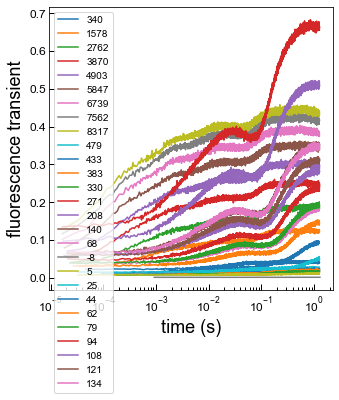

<Figure size 432x288 with 0 Axes>

In [4]:
p.figsize = (10, 10)
fig1 = p.set_figure("%e", "%0.1f")
ax1 = plt.gca()
t_list = []
y_list = []
intensity_list = []
voltage_list = []
filter_list = []
for i, folder in enumerate(folder_list[0:1]): 
    print(folder)
    for k, f in enumerate(glob.glob(folder + "/*pulse*")):
        t, y, voltage, intensity, filter, intensity_purple = open_curve(f, N= 50)
        t_list.append(t)
        y_list.append(y)
        filter_list.append(filter)
        intensity_list.append(intensity)
        voltage_list.append(voltage)
        if k>8:
            ax1.semilogx(t,y, label = int(intensity))
        
ax1.legend()
ax1.set_xlabel("time (s)")
ax1.set_ylabel("fluorescence transient")
p.save_name = 'OJIP_algae_%s'%folder[:-1]
u = p.saving(fig1)

LEAF4_blue_665_657_filter_012/


Text(0, 0.5, 'fluorescence transient')

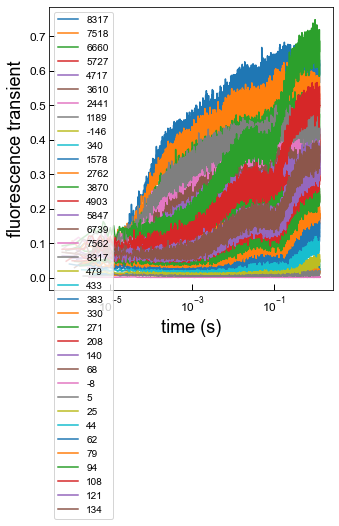

In [5]:
p.figsize = (10, 10)
fig1 = p.set_figure("%e", "%0.1f")
ax1 = plt.gca()
t_list = []
y_list = []
intensity_list = []
voltage_list = []
for i, folder in enumerate(folder_list): 
    print(folder)
    for f in glob.glob(folder + "/*pulse*"):
        t, y, voltage, intensity, filter, intensity_purple = open_curve(f, N= 2)
        t_list.append(t)
        y_list.append(y)
        intensity_list.append(intensity)
        voltage_list.append(voltage)
        ax1.semilogx(t,y, label = int(intensity))
        
ax1.legend()
ax1.set_xlabel("time (s)")
ax1.set_ylabel("fluorescence transient")


In [6]:
print(np.mean(y_list[8]))
print(np.mean(y_list[26]))

0.0015253364397194834
0.0013338246590909114


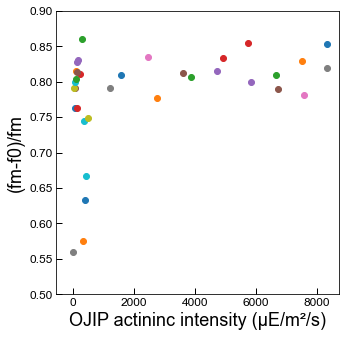

<Figure size 432x288 with 0 Axes>

In [7]:



p.figsize = (10, 10)
fig1 = p.set_figure("%d", "%0.2f")
ax1 = plt.gca()

for i, y in enumerate(y_list):
        if i<20:
            y = y-np.mean(y_list[8])
        else:
            y = y-np.mean(y_list[26])

        mini= np.argmin(y)
        f0 = np.mean(y[max(mini-2, 0):mini+2])
        maxi = np.argmax(y)
        fm = np.mean(y[maxi-10:maxi+10])
        plt.scatter(intensity_list[i], (fm-f0)/fm)
        plt.ylim(0.5, 0.9)
        plt.xlabel("OJIP actininc intensity (µE/m²/s)")
        plt.ylabel("(fm-f0)/fm")

p.save_name = 'OJIP_quantum_yield_%s'%folder[:-1]
u = p.saving(fig1)

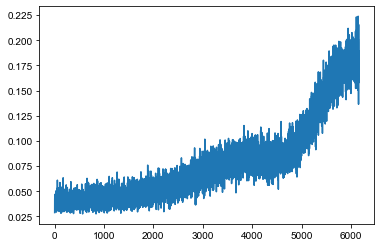

In [8]:
plt.plot(y_list[25])

### same_leaf OJIP and IBPC:

In [9]:
OJIP = ["LEAF_OJIP_PULSE_OJIP"]

LEAF_OJIP_PULSE_OJIP


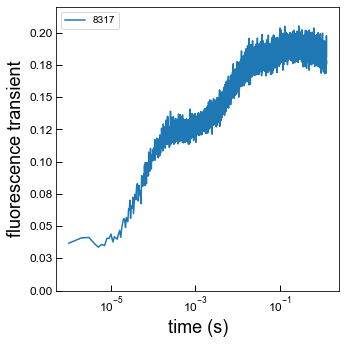

<Figure size 432x288 with 0 Axes>

In [31]:
p.figsize = (10, 10)
fig1 = p.set_figure("%e", "%0.2f")
ax1 = plt.gca()
t_list = []
y_list = []
intensity_list = []
voltage_list = []
filter_list = []
for i, folder in enumerate(OJIP): 
    print(folder)
    for k, f in enumerate(glob.glob(folder + "/*pulse*")[0:1]):
        t, y, voltage, intensity, filter, intensity_purple = open_curve(f, N= 3)
        t_list.append(t)
        y_list.append(y)
        filter_list.append(filter)
        intensity_list.append(intensity)
        voltage_list.append(voltage)
        ax1.semilogx(t,y/4, label = int(intensity))
        ax1.set_ylim(0, 0.22)
        
ax1.legend()
ax1.set_xlabel("time (s)")
ax1.set_ylabel("fluorescence transient")
p.save_name = 'OJIP_algae_%s'%folder[:-1]
u = p.saving(fig1)

In [24]:
np.mean(y_list[0][-2000:-100])/np.mean(y_list[0][0:5])

4.959553901038165

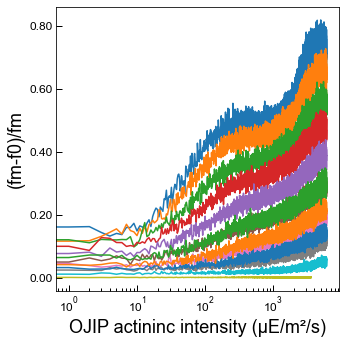

<Figure size 432x288 with 0 Axes>

In [16]:

p.figsize = (10, 10)
fig1 = p.set_figure("%d", "%0.2f")
ax1 = plt.gca()

PSII = []

for i, y in enumerate(y_list):
        if i<5:
            y = y-np.mean(y_list[8])
        plt.semilogx(y)
        plt.xlabel("OJIP actininc intensity (µE/m²/s)")
        plt.ylabel("(fm-f0)/fm")

p.save_name = 'OJIP_quantum_yield_%s'%folder[:-1]
u = p.saving(fig1)

0.13869822074877203 0.7622617040821055
0.09960208741543873 0.6567133040821054
0.11475902074877206 0.5597147874154387
0.09397675408210546 0.4769334707487721
0.06180792074877214 0.38378157074877217
-0.032949724339851924 0.20106004232681474
-0.04922159100651865 0.10305887566014804
-0.06208705767318528 0.031835642326814725
-0.08412489100651857 -0.0836586910065186
-0.07182742433985193 -0.03186382433985194
-0.05814402433985197 0.057308658993481386
-0.046231757673185256 0.13406102566014805
-0.030465457673185266 0.2140633923268147


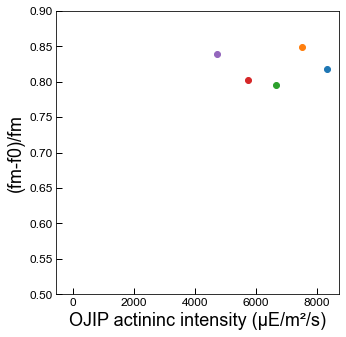

<Figure size 432x288 with 0 Axes>

In [11]:



p.figsize = (10, 10)
fig1 = p.set_figure("%d", "%0.2f")
ax1 = plt.gca()

PSII = []

for i, y in enumerate(y_list):
        if i<5:
            y = y-np.mean(y_list[8])
        else:
            y = y-np.mean(y_list[(26-11)//2])

        mini= np.argmin(y)
        f0 = np.mean(y[max(mini-1, 0):mini+1])
        maxi = np.argmax(y)
        fm = np.mean(y[maxi-10:maxi+10])
        print(f0, fm)
        PSII.append((fm-f0)/fm)
        plt.scatter(intensity_list[i], (fm-f0)/fm)
        plt.ylim(0.5, 0.9)
        plt.xlabel("OJIP actininc intensity (µE/m²/s)")
        plt.ylabel("(fm-f0)/fm")

p.save_name = 'OJIP_quantum_yield_%s'%folder[:-1]
u = p.saving(fig1)

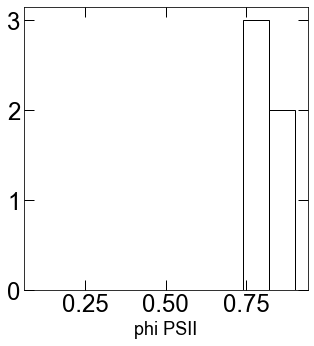

<Figure size 432x288 with 0 Axes>

In [12]:
fig = p.set_figure("%0.2f", "%d")
ax = plt.gca()

p.save_name = "leaf_ojip_hist"
p.extension = ".png"
plt.xlabel(r"phi PSII")
plt.ylabel("")
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=24, direction = 'in', top = True, right = True, length = 10 )
_, bins, _ = plt.hist(np.array(PSII), bins=10, range = [0.1,0.9], density= False, alpha=1, facecolor = "white", edgecolor = "black")

u = p.saving(fig)

